In [1]:
from knn_chain import knn_chain, get_top_k
from py_knn_chain import py_knn_chain
from nn_chain_algorithm_standard import standard_nn_chain

# from scipy.cluster.hierarchy import ward, dendrogram, linkage
from scipy.spatial.distance import pdist

import numpy as np
import time

import pstats, cProfile
import pyximport
pyximport.install()

(None, <pyximport._pyximport3.PyxImportMetaFinder at 0x754e446d5fc0>)

## Data

In [3]:
def generate_multivariate_gaussian_data(num_samples, num_features, num_distributions):
    """
    Generate a massive multidimensional, multivariate Gaussian dataset.

    Parameters:
    - num_samples: Total number of samples to generate.
    - num_features: Number of features (dimensions) for each sample.
    - num_distributions: Number of different Gaussian distributions.

    Returns:
    - data: Generated dataset of shape (num_samples, num_features).
    """
    data = []
    samples_per_distribution = num_samples // num_distributions

    for i in range(num_distributions):
        mean = np.random.rand(num_features) * 100
        cov = np.random.rand(num_features, num_features)
        cov = np.dot(cov, cov.transpose())

        distribution_data = np.random.multivariate_normal(mean, cov, samples_per_distribution)
        data.append(distribution_data)

    data = np.vstack(data)
    return data

In [2]:
# num_samples = 1000
# num_features = 10
# num_distributions = 4

# X = list(generate_multivariate_gaussian_data(num_samples, num_features, num_distributions))

# np.savetxt("X", X)
X = list(np.loadtxt("X"))

## Profiling

## 1. Python Algorithms

In [3]:
for i in range(10):
    cProfile.runctx("py_knn_chain(X, k = 1)", globals(), locals(), "Profile.prof")

In [9]:
avg = 0.0

for i in range(5):
    cProfile.runctx("py_knn_chain(X, k = 3)", globals(), locals(), "Profile.prof")
    s = pstats.Stats("Profile.prof")
    avg += s.strip_dirs().sort_stats("time").total_tt
    
print(f"avg = {avg/5}")
s.strip_dirs().sort_stats("time").print_stats()

avg = 4.497350163
Thu Jun 20 12:22:49 2024    Profile.prof

         1114254 function calls in 4.423 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1066146    3.719    0.000    3.719    0.000 py_knn_chain.py:7(ward)
     2106    0.419    0.000    4.129    0.002 py_knn_chain.py:21(<listcomp>)
     4212    0.085    0.000    0.085    0.000 {built-in method numpy.array}
     2106    0.079    0.000    0.079    0.000 py_knn_chain.py:20(<listcomp>)
     2106    0.052    0.000    0.052    0.000 {method 'argsort' of 'numpy.ndarray' objects}
        1    0.034    0.034    4.422    4.422 py_knn_chain.py:26(py_knn_chain)
     2106    0.020    0.000    4.370    0.002 py_knn_chain.py:18(get_top_k)
     2659    0.003    0.000    0.060    0.000 fromnumeric.py:53(_wrapfunc)
     2106    0.002    0.000    0.057    0.000 fromnumeric.py:1025(argsort)
      553    0.002    0.000    0.004    0.000 fromnumeric.py:40(_wrapit)
      553    0.001

In [9]:
y = pdist(X)

In [10]:
avg = 0.0

for i in range(10):
    cProfile.runctx("standard_nn_chain(y, len(X))", globals(), locals(), "Profile.prof")
    s = pstats.Stats("Profile.prof")
    avg += s.strip_dirs().sort_stats("time").total_tt
    
print(f"avg = {avg/10}")
s.strip_dirs().sort_stats("time").print_stats()

avg = 31.896431360499996
Thu Jun 20 12:01:39 2024    Profile.prof

         3447241 function calls in 31.334 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  2945723   19.240    0.000   19.240    0.000 nn_chain_algorithm_standard.py:49(condensed_index)
        1   10.370   10.370   31.334   31.334 nn_chain_algorithm_standard.py:61(standard_nn_chain)
   498501    1.716    0.000    1.716    0.000 nn_chain_algorithm_standard.py:45(new_dist)
     1998    0.005    0.000    0.005    0.000 nn_chain_algorithm_standard.py:21(find)
        1    0.002    0.002    0.008    0.008 nn_chain_algorithm_standard.py:32(label)
      999    0.001    0.000    0.001    0.000 nn_chain_algorithm_standard.py:13(merge)
        1    0.000    0.000    0.000    0.000 {method 'argsort' of 'numpy.ndarray' objects}
        1    0.000    0.000   31.334   31.334 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 numeric.py:136(one

## 2. Cython Algorithms

In [17]:
# np.savetxt("largeX", X)
X = list(np.loadtxt("largeX"))
print(f"shape of X: {len(X), len(X[0])}")

shape of X: (10000, 100)


### - get_top_k()

In [18]:
for i in range(50):
    cProfile.runctx("get_top_k(i = 0, size = np.ones(shape=len(X)), pos = X, active=set([i for i in range(len(X))]), k = 3)", globals(), locals(), "Profile.prof")

In [19]:
avg = 0.0

for i in range(50):
    cProfile.runctx("get_top_k(i = 0, size = np.ones(shape=len(X)), pos = X, active=set([i for i in range(len(X))]), k = 3)", globals(), locals(), "Profile.prof")
    s = pstats.Stats("Profile.prof")
    avg += s.strip_dirs().sort_stats("time").total_tt
    
print(f"avg = {avg/50}")
s.strip_dirs().sort_stats("time").print_stats()
#0.009262675739999999

avg = 0.009262675739999999
Tue Jun 11 15:09:42 2024    Profile.prof

         10019 function calls (10018 primitive calls) in 0.009 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     9999    0.004    0.000    0.004    0.000 knn_chain.pyx:9(ward)
      2/1    0.003    0.002    0.008    0.008 knn_chain.pyx:23(get_top_k)
        1    0.001    0.001    0.001    0.001 {method 'argsort' of 'numpy.ndarray' objects}
        1    0.001    0.001    0.001    0.001 <string>:1(<listcomp>)
        1    0.000    0.000    0.009    0.009 <string>:1(<module>)
        1    0.000    0.000    0.009    0.009 {built-in method builtins.exec}
        2    0.000    0.000    0.001    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(copyto)
        1    0.000    0.000    0.001    0.001 fromnumeric.py:51(_wrapfunc)
        1    0.000    0.000

### - knn_chain()

In [9]:
# np.savetxt("X", X)
X = list(np.loadtxt("X"))
print(f"shape of X: {len(X), len(X[0])}")

shape of X: (1000, 10)


In [15]:
for i in range(10):
    cProfile.runctx("knn_chain(X, k = 3)", globals(), locals(), "Profile.prof")

In [16]:
avg = 0.0

for i in range(10):
    cProfile.runctx("knn_chain(X, k = 3)", globals(), locals(), "Profile.prof")
    s = pstats.Stats("Profile.prof")
    avg += s.strip_dirs().sort_stats("time").total_tt
    
print(f"avg = {avg/10}")
s.strip_dirs().sort_stats("time").print_stats()
#0.9169820677

avg = 0.9169820677
Tue Jun 11 15:08:35 2024    Profile.prof

         1099421 function calls (1099420 primitive calls) in 0.915 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1076618    0.574    0.000    0.574    0.000 knn_chain.pyx:9(ward)
     2131    0.223    0.000    0.850    0.000 knn_chain.pyx:23(get_top_k)
      2/1    0.059    0.030    0.915    0.915 knn_chain.pyx:41(knn_chain)
     2131    0.048    0.000    0.048    0.000 {method 'argsort' of 'numpy.ndarray' objects}
     2698    0.002    0.000    0.053    0.000 fromnumeric.py:51(_wrapfunc)
     2131    0.001    0.000    0.054    0.000 <__array_function__ internals>:177(argsort)
      567    0.001    0.000    0.003    0.000 fromnumeric.py:38(_wrapit)
     2131    0.001    0.000    0.051    0.000 fromnumeric.py:1038(argsort)
     2698    0.001    0.000    0.056    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      567    0.001    

## Comparison

In [12]:
# WIP
# get the start time
st = time.process_time()
########## FIX 
A = knn_chain(X, k = 3)
##########
# get the end time
et = time.process_time()
# get execution time
res = et - st
print('CPU Execution time:', res, 'seconds')

CPU Execution time: 0.395937966 seconds


In [14]:
# Python Implementation
# get the start time
st = time.process_time()
########## FIX 
B = py_knn_chain(X, k = 3)
##########
# get the end time
et = time.process_time()
# get execution time
res = et - st
print('CPU Execution time:', res, 'seconds')

<class 'numpy.ndarray'>
CPU Execution time: 6.008719696 seconds


In [13]:
# SciPy implementation
# get the start time
st = time.process_time()
########## FIX 
y = pdist(X) 
Z = ward(y)
##########
# get the end time
et = time.process_time()
# get execution time
res = et - st
print('CPU Execution time:', res, 'seconds')
# dendrogram(Z);

CPU Execution time: 0.018500914000000535 seconds


## Dendrogram comparison

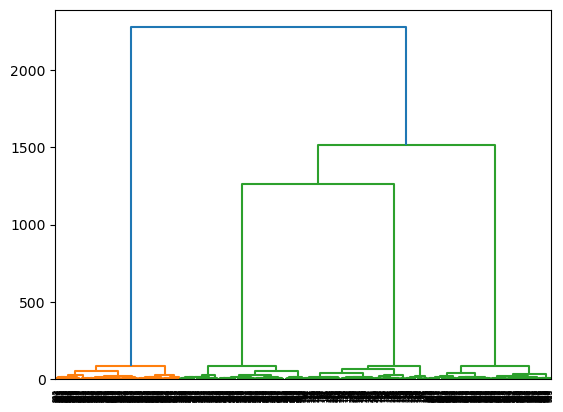

In [18]:
dendrogram(A);

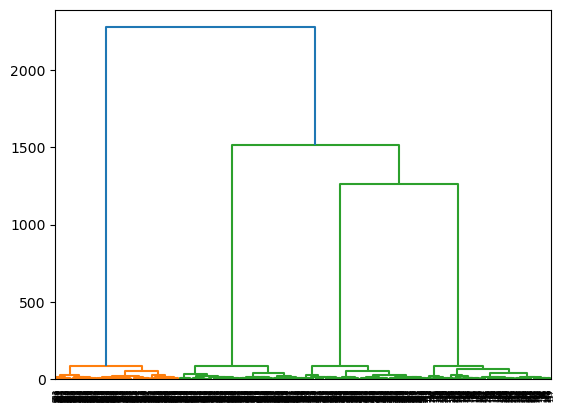

In [17]:
dendrogram(Z);